# <center>  CS231n <center>

![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/1.jpg)

## 卷积层
<br>
<font size=2>
由于卷积神经网络通常有很多层，不希望过早地使卷积操作后的尺寸缩小，因而在 stride=1 的前提下，进行zero padding使得卷积前和卷积后的尺寸一致。 那么对于 $F \times F$ 的原始尺寸，zero padding 数为 $\frac{F-1}{2}$， 如：
<br><br>
$$
\begin{align}
\text{F} = 3 \;\; \longrightarrow \;\; \text{zero padding with 1} \\
\text{F} = 5 \;\; \longrightarrow \;\; \text{zero padding with 2} \\
\text{F} = 7 \;\; \longrightarrow \;\; \text{zero padding with 3} 
\end{align}
$$
<br><br>
卷积后输出大小的计算：
$$
\text{output size} = \frac{\text{input size} + 2 \times \text{padding size} - \text{filter size}}{\text{stride}} + 1
$$
</font>

卷积运算图示，分别加了 bias 和 batch：
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/2.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/3.png)

### 卷积层的可视化

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [22]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, cmap="hot", interpolation="gaussian")
    plt.axis("off")

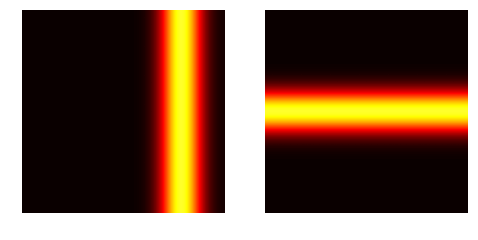

In [9]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 5, 0, 0] = 1
fmap[3, :, 0, 1] = 1
plt.figure(figsize=(8, 5))
plt.subplot(121)
plot_color_image(fmap[:, :, 0, 0])
plt.subplot(122)
plot_color_image(fmap[:, :, 0, 1])

In [24]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

In [25]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

sess = tf.InteractiveSession()
output = convolution.eval(feed_dict={X: images})

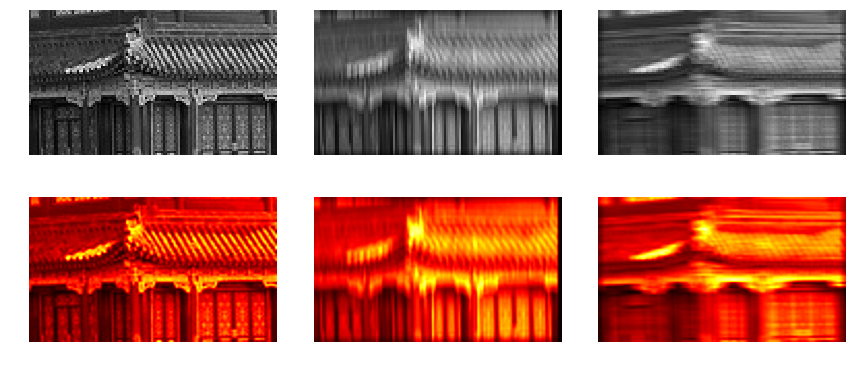

In [26]:
plt.figure(figsize=(12,12))
plt.subplot(231)
plot_image(images[0, :, :, 0])
plt.subplot(232)
plot_image(output[0, :, :, 0])
plt.subplot(233)
plot_image(output[0, :, :, 1])
plt.subplot(234)
plot_color_image(images[0, :, :, 0])
plt.subplot(235)
plot_color_image(output[0, :, :, 0])
plt.subplot(236)
plot_color_image(output[0, :, :, 1])
plt.subplots_adjust(top=1.7)
plt.tight_layout()

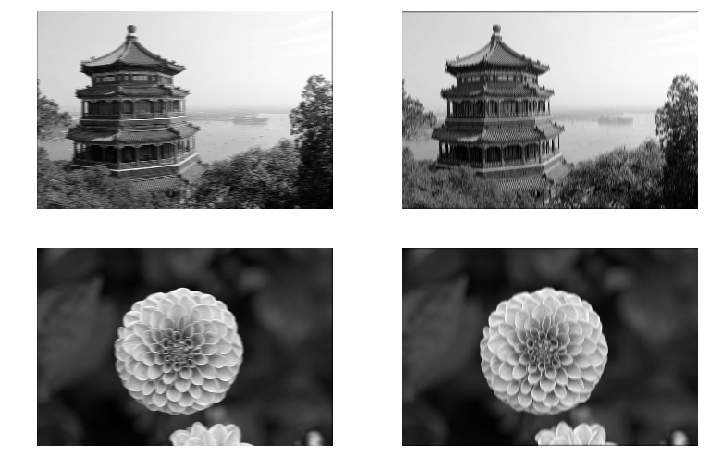

In [32]:
reset_graph()
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

X = tf.placeholder(tf.float32, shape=[None, height, width, channels])
filters = np.zeros((7, 7, channels, 2))
filters[3, :, :, 0] = 1
filters[:, 3, :, 1] = 1
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: dataset})

i = 1
plt.figure(figsize=(12, 8))
for image_index in [0, 1]:
    for feature_map_index in [0, 1]:
        plt.subplot(2, 2, i)
        plot_image(output[image_index, :, :, feature_map_index])
        i += 1

-----

## 池化层
<br>
<font size=2>
pooling layer 的特点:   
    <br>
1. 没有要学习的参数  
2. 独立地作用于每个 feature map，通道数不发生变化。  
3. 通常没有 zero padding  

</font>

### ResNet
<br>
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/4.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/5.png)

### im2col 函数示意图

![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/6.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/7.png)

In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    input_data : 由(数据量, 通道, 高, 长)的4维数组构成的输入数据
    filter_h : 滤波器的高
    filter_w : 滤波器的长
    stride : 步幅
    pad : 填充

    Returns
    -------
    col : 2维数组
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1
    
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

### 卷积层和池化层的实现

In [3]:
class Covolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        
    def forward(self, x):
        FN, C,FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        self.x = x
        self.col = col
        self.col_W = col_W
        return out
    
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

In [4]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

In [5]:
# coding: utf-8
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

-----

# <center>  CS224n <center>

<font size=2>
    RNN 的缺点： 只能在 sequence 的最后阶段作预测，而有些如 sentiment classification 问题，只关注句子中的几个特定词，而CNN会计算所有的 possible phrase。
    <br>
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/8.png)
<br><br><br>
<font>

<font size=3>
filter 是一个 vector，$k$ 为 word vector 长度， $\mathbb{R}^{hk}$ 为长度为 $hk$ 的filter，$h$ 为 window size。
</font>

<br>
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/9.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/10.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/11.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/12.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/13.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/14.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/15.png)
![](https://raw.githubusercontent.com/massquantity/Deep_Learning_NOTES/master/pic/CNN/16.png)